# **Group Project - Option B**


**Importing Relevant Packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from sklearn.covariance import EmpiricalCovariance

import warnings
warnings.filterwarnings('ignore')

**Reading CSV file**

In [2]:
# Read the CSV file
data = pd.read_csv('gp_data_1986_to_2015.csv', index_col = 'Month')

**Calulating Excess Returns**

In [3]:
# getting excess returns df
excess_returns = data.iloc[:, -43:]
excess_returns = excess_returns.apply(lambda x: (x - data['RF']))
excess_returns.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
Month,,,,,,,,,,,,,,,,,,,,,
198601,7.36,1.82,-1.76,-1.42,4.99,1.58,3.35,-1.34,-1.52,4.66,...,0.22,-1.67,0.29,3.24,4.05,1.35,5.04,1.92,1.11,-0.65
198602,13.45,7.36,11.15,7.18,11.67,10.19,7.75,14.14,10.20,8.80,...,6.94,2.18,7.81,9.45,8.15,10.08,6.50,8.32,6.68,8.74
198603,2.14,7.24,10.29,8.57,10.92,5.05,6.26,4.47,4.97,5.57,...,4.36,-0.71,-0.56,-1.75,3.58,5.01,2.62,6.81,8.51,5.82
198604,4.72,-1.09,3.92,-3.44,3.12,3.39,7.84,-1.66,-2.18,-3.30,...,2.81,3.35,3.03,2.17,-3.02,-1.45,-3.16,1.18,-1.22,3.34
198605,0.59,8.06,7.46,5.88,9.67,2.67,5.42,10.47,4.12,9.29,...,4.92,0.52,-1.24,2.02,6.17,4.58,0.21,5.03,11.46,4.40


**1.2 Basic Portfolio Construction and In-Sample Analysis**
-

**Helper functions - Getting portfolio weights**

In [4]:
# helper function to get mu and V
# combining estimate_mu and estimate_V

def mu_V (df):

    return [EmpiricalCovariance().fit(df).location_, EmpiricalCovariance().fit(df).covariance_]

In [5]:
# helper function to get portfolio weights
def portfolio_weights(input_list, port_type):

    if port_type == 'tan':
        mu, V = input_list[0], input_list[1]
        w_t = np.linalg.inv(V) @ mu
        w_t /= np.sum(w_t)
        return w_t

    elif port_type == 'gmv':
        V = input_list[0]
        n = len(V)
        w_g = np.linalg.inv(V) @ np.ones(n)
        w_g /= np.sum(w_g)
        return w_g

    elif port_type == 'ewp':
        n = len(input_list[0].columns)
        return np.ones(n)/n

**Getting Weights**

In [6]:
# helper function to get non-robust weights
def get_standard_weights(excess_returns):
    # using portfolio_weights function to get weights
    weight_inputs, basic_port = [[excess_returns], mu_V(excess_returns), [mu_V(excess_returns)[1]]], ['ewp', 'tan', 'gmv']

    # Create lists of weights using function
    ew_w, tan_w, gmv_w = [portfolio_weights(weight_inputs[i], basic_port[i]) for i in range(len(basic_port))]

    # Zip lists together
    weights_df = pd.DataFrame(zip(ew_w, tan_w, gmv_w), 
                                columns = [str(i.upper())+ ' Weights' for i in basic_port],
                                index = excess_returns.columns.to_list())
    
    return weights_df

In [7]:
# applying function 
weights_df = get_standard_weights(excess_returns)
weights_df.head()

,EWP Weights,TAN Weights,GMV Weights
Agric,0.023256,-0.050933,0.080757
Food,0.023256,0.158097,0.099587
Soda,0.023256,0.057595,-0.004510
Beer,0.023256,0.143384,-0.011566
Smoke,0.023256,0.259716,-0.041839


**Helper functions - Getting portfolio metrics**

In [8]:
# helper function to evaluate portfolio performance
def evaluate_portfolio_performance(w, data_evaluate):
    
    ###########
    # Evaluate the performance of a portfolio (i.e., weight vector) given the expected return vector
    # and covariance matrix
    # Input: mu is the expected return vector, V is the covariance matrix, and rf is the risk free rate (default 0)
    #        w is the portfolio weight vector
    # Output: The performance metrics of the portfolio 
    #         (i.e., expected return, standard deviation, variance, and Sharpe ratio)
    ###########
    
    w = np.array(w)
    if (data_evaluate.shape[1] != len(w)):
        print('Warning: data and w should contain the same number of assets')
    
    mu, V = mu_V(data_evaluate)

    return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w), 
            'var': w.T @ V @ w, 'Sharpe': (mu.T @ w - 0)/(np.sqrt(w.T @ V @ w)) }

In [9]:
def get_metrics(weights_df, excess_returns):
    metrics_df, metrics_inds = pd.DataFrame(), []

    for i in weights_df.columns:
        metrics_df = pd.concat([metrics_df,pd.DataFrame.from_dict(evaluate_portfolio_performance(weights_df[i].to_list(), excess_returns), orient = 'index')], axis = 1)
        metrics_inds.append(i[:3]) # getting only the words
        
    metrics_df = metrics_df.set_axis(metrics_inds, axis = 1)

    return metrics_df

In [10]:
metrics_df = get_metrics(get_standard_weights(excess_returns), excess_returns)
metrics_df.head()

,EWP,TAN,GMV
Er,0.718348,1.916838,0.562142
sigma,4.650387,5.281517,2.860151
var,21.626103,27.894421,8.180464
Sharpe,0.154470,0.362933,0.196543


In [11]:
# function to get market portfolio metrics
def get_market_metrics(metrics_df, data):
    mkt_er, mkt_std, mkt_var, mkt_sharpe = data['Mkt-RF'].mean(), data['Mkt-RF'].std(), data['Mkt-RF'].var(), data['Mkt-RF'].mean()/data['Mkt-RF'].std()
    metrics_df['MKT'] = [mkt_er, mkt_std, mkt_var, mkt_sharpe]

    return metrics_df

In [12]:
metrics_df = get_market_metrics(get_metrics(get_standard_weights(excess_returns), excess_returns), data)
metrics_df.head()

,EWP,TAN,GMV,MKT
Er,0.718348,1.916838,0.562142,0.636361
sigma,4.650387,5.281517,2.860151,4.484527
var,21.626103,27.894421,8.180464,20.110982
Sharpe,0.154470,0.362933,0.196543,0.141902


**Helper Function: In-sample Analysis Graph**

In [13]:
def get_EF_on_data (w_t, w_g, data_evaluate):

    ###########
    # Get the (evaluated) efficient frontier curve using the two-fund separation method
    #
    # Input: data contains historical return information to evaluate on (every column corresponds to an asset)
    #        w_t and w_g are the constructed tangency and global minimum variance portfolios, respectively
    #        (NB: if w_t and w_g are obtained from the training data but "data" is actually testing data,
    #         then the output EF could be highly sub-optimal!)
    # Output: The risk-return combinations of portfolios on the (evaluated) EF 
    ###########
    
    trange = np.arange(0,2,0.01)
    sigma_range = np.zeros_like (trange) * np.nan
    Er_range = np.zeros_like (trange) * np.nan

    for i in np.arange(len(trange)):
        w_mix = trange[i] * w_t + (1-trange[i]) * w_g
        sigma_range[i] = evaluate_portfolio_performance(w_mix, data_evaluate) ['sigma']
        Er_range[i] = evaluate_portfolio_performance(w_mix, data_evaluate) ['Er']
        
    return sigma_range, Er_range

**Helper Function: Efficient Frontier**

In [14]:
def plot_ef(data_train):

    ###########
    # A Summary function
    #
    # Input: The portfolios are all obtrained from "data_train"; 
    #        Their performances are all evaluated on "data_train" as well
    # Output: A plot that contrains tangency portfolio, GMV, EF, and equally weighted portfolio
    ###########
    plt.figure(figsize = (8,5))
    
    # Obtain the tangency, GMV, equally weighted portfolios from the TRAINING data
    mu_train, V_train = mu_V(data_train)

    # Obtain inputs for Portfolio Weights function, create weights list
    weight_inputs, basic_port = [[data_train], mu_V(data_train), [mu_V(data_train)[1]]], ['ewp', 'tan', 'gmv']
    w_list = w_e, w_t_train, w_g_train = [portfolio_weights(weight_inputs[i], basic_port[i]) for i in range(len(basic_port))]

    # Obtain efficient frontier using Two-fund separation method
    sigma_range, Er_range = get_EF_on_data (w_t_train, w_g_train, data_train)
    plt.plot(sigma_range, Er_range, label = 'EF')
    
    # Pyplot function
    markers, color, labels = ['o' for i in range(3)], ['g', 'r', 'purple'], ['EWP', 'TAN', 'GMV']

    # Plot portfolios
    for i in range(len(w_list)):
        plt.scatter(evaluate_portfolio_performance(w_list[i], data_train)['sigma'], 
                    evaluate_portfolio_performance(w_list[i], data_train)['Er'], 
                    marker= markers[i], 
                    c = color[i] ,
                    label = labels[i])

    # Plot market portfolio
    plt.scatter(metrics_df.at['sigma', 'MKT'] , 
                metrics_df.at['Er', 'MKT'] , marker='o', color = 'orange',label = 'MKT')

    # Plot assets
    er_list, vol_list = [], []
    for i in data_train.columns:
        er_list.append(data_train[i].mean())
        vol_list.append(data_train[i].std())
    
    plt.scatter(vol_list, er_list, marker='+', c = 'gray' ,label = 'Assets')

    plt.legend()
    plt.title('Risk-Return Diagram (Efficient Frontier)')
    plt.xlabel('$\sigma$')
    plt.ylabel('E[r]')
    
    plt.show()

**Deliverable**
-


In [15]:
# getting covariance matrix
v = pd.concat([data['Mkt-RF'], excess_returns], axis=1).cov()
mkt_var = v.at['Mkt-RF', 'Mkt-RF']

# get list of betas
cov_beta = [(i/mkt_var) for i in v['Mkt-RF'].values.tolist()]
stock_betas = cov_beta[1:]

# create df
betas_df, port_betas, cols = weights_df.copy(), [], []
betas_df['Betas'] = stock_betas

for i in betas_df.columns[:3]:
    port_betas.append((betas_df['Betas']*betas_df[i]).sum())
    cols.append(i)
port_betas.append(1)
metrics_df.loc[len(metrics_df)] = port_betas
metrics_df = metrics_df.rename(index = {4: 'Beta'})

In [16]:
metrics_df

,EWP,TAN,GMV,MKT
Er,0.718348,1.916838,0.562142,0.636361
sigma,4.650387,5.281517,2.860151,4.484527
var,21.626103,27.894421,8.180464,20.110982
Sharpe,0.154470,0.362933,0.196543,0.141902
Beta,0.983295,0.526035,0.400154,1.000000


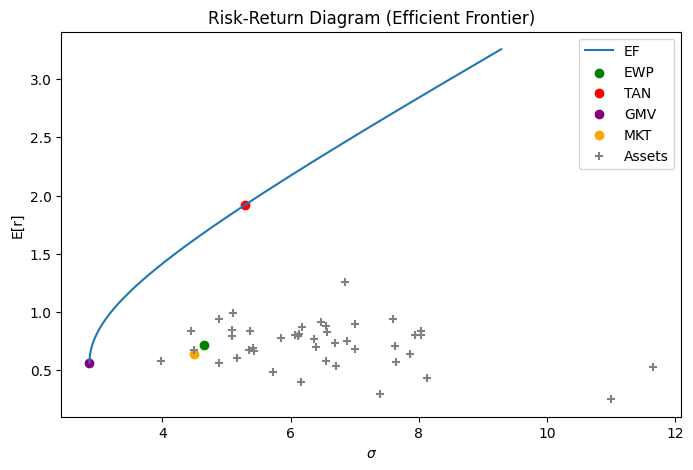

In [17]:
# using helper functions above to plot efficient frontier
plot_ef(excess_returns)

**Security Market Line (SML)**

In [18]:
def plot_sml(data_train):
    
    plt.figure(figsize = (8,5))

    # Plot SML (CAPM definition)
    rm, bs = data['Mkt-RF'].mean(), np.arange(0, 2, 0.01)
    assetReturns = [rm*x for x in bs] # RF rate is 0
    plt.plot(bs, assetReturns, label = 'SML')

    # Plot betas for portfolios
    for i in range(len(metrics_df.columns)):
        plt.scatter(metrics_df.iat[4, i],
                    metrics_df.iat[0, i],
                    label = metrics_df.columns[i]
                    )

    # Plot betas for assets
    er_list = []
    for i in data_train.columns:
        er_list.append(data_train[i].mean())  
    plt.scatter(stock_betas, er_list, marker='+', c = 'gray' ,label = 'Assets')

    # Plot params
    plt.legend()
    plt.title('Beta-Return Diagram (Security Market Line)')
    plt.xlabel(r'$\beta$')
    plt.ylabel('E[r]')

    plt.show()

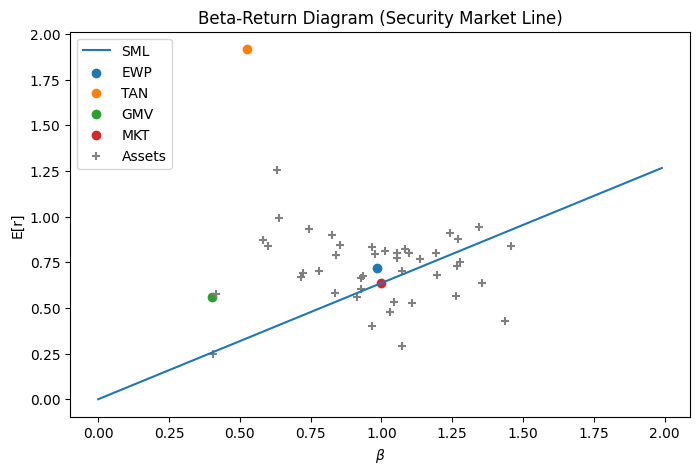

In [19]:
# use the function above to plot SML
plot_sml(excess_returns)

**1.3 Robust Portfolio Construction and Out-of-Sample Analysis**
-

**Splitting into Train and Test**

In [20]:
# train-test split
excess_returns_train = excess_returns.loc[:'201012', :]
excess_returns_test = excess_returns.loc['201101':, :]

# Mkt-RF Split
mkt_train = data.loc[:'201012'] 
mkt_test = data.loc['201101':] 

In [21]:
# helper function to get beta

def create_betas(df, ex_rets):
    v = pd.concat([df['Mkt-RF'], ex_rets], axis=1).cov()
    mkt_var = v.at['Mkt-RF', 'Mkt-RF']

    # Find list of betas
    cov_beta = [(i/mkt_var).round(5) for i in v['Mkt-RF'].values.tolist()]
    stock_betas = cov_beta[1:]

    return pd.DataFrame(zip(ex_rets.columns.tolist(), stock_betas), columns = ['Industry', 'Beta'])

# Get betas for train and test
train_betas = create_betas(mkt_train, excess_returns_train)

In [22]:
# get betas for train and test set
train_beta = create_betas(mkt_train, excess_returns_train)
test_beta = create_betas(mkt_test, excess_returns_test)

train_beta.head()

,Industry,Beta
0,Agric,0.73990
1,Food,0.59697
2,Soda,0.86344
3,Beer,0.66278
4,Smoke,0.62689


**Estimating Beta**

In [23]:
# getting beta shrink
def get_beta_shrink(betas_df):
    grand_mean = betas_df.Beta.mean()

    # Shrunken betas xd
    betas_df['Beta Shrink'] = betas_df['Beta'].apply(lambda x: 0.5 * grand_mean + 0.5 * x)

    return betas_df


In [24]:
train_beta = get_beta_shrink(train_beta)
train_beta.head()

,Industry,Beta,Beta Shrink
0,Agric,0.73990,0.857013
1,Food,0.59697,0.785548
2,Soda,0.86344,0.918783
3,Beer,0.66278,0.818453
4,Smoke,0.62689,0.800508


**Estimating Expected Return**

In [25]:
# getting expected returns using CAPM
def get_capm_returns(df, betas_df):
    rm = df['Mkt-RF'].mean()
    betas_df['CAPM_Mu'] = betas_df['Beta Shrink'] * rm
    
    return betas_df

In [26]:
train_estimates = get_capm_returns(mkt_train, train_beta)
train_estimates.head()

,Industry,Beta,Beta Shrink,CAPM_Mu
0,Agric,0.73990,0.857013,0.481185
1,Food,0.59697,0.785548,0.441059
2,Soda,0.86344,0.918783,0.515866
3,Beer,0.66278,0.818453,0.459534
4,Smoke,0.62689,0.800508,0.449459


**Estimating Correlation Matrix**

In [27]:
# function to get constant correlation matrix
def get_const_corr(excess_returns):

    # Obtain covariance matrix (43x300)
    sample_cov_matrix = excess_returns.cov()
    sample_cov_matrix = sample_cov_matrix.values


    # Obtain sigma (43x1)
    var = np.diag(sample_cov_matrix).reshape(-1, 1)
    std = np.sqrt(var)

    # Obtain rho bar
    n = len(excess_returns.columns)
    _std = np.tile(std, (n,))
    r_bar = (np.sum(sample_cov_matrix / (_std * _std.T)) - n) / (n * (n - 1))

    # Obtain constant correl
    vcc = r_bar * (_std * _std.T)
    vcc[np.eye(n) == 1] = var.reshape(-1)

    return vcc


In [28]:
# function to get vshrink
def get_vshrink(excess_returns, shrink_coeff):
    
    sample_cov_matrix = excess_returns.cov()
    sample_cov_matrix = sample_cov_matrix.values  

    # Obtain constant correl matrix
    const_corr_matrix = get_const_corr(excess_returns)

    return pd.DataFrame(shrink_coeff * const_corr_matrix + (1-shrink_coeff) * sample_cov_matrix)


In [29]:
vshrink_train = get_vshrink(excess_returns_train, 0.3)
vshrink_train.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,42.451075,12.777359,17.209770,14.250394,16.219475,18.914251,22.638322,18.296609,13.223025,20.850108,...,20.903907,21.584443,23.892899,22.037766,16.420213,18.782065,17.231559,16.281772,17.546442,16.058984
1,12.777359,21.779965,17.443900,15.594761,18.491971,16.165161,17.568479,14.612466,13.324245,17.727510,...,13.496575,12.765217,13.542835,14.209125,13.929295,14.572044,13.161099,13.146036,14.960421,14.271160
2,17.209770,17.443900,55.908805,22.182191,20.202499,23.873275,29.542519,22.979945,19.239053,25.678783,...,21.233660,22.694546,25.323608,24.002609,21.703203,21.708653,20.390975,20.700827,20.286513,20.347367
3,14.250394,15.594761,22.182191,29.627435,17.614668,18.133782,19.659889,14.860450,16.521366,18.113976,...,15.614236,15.218682,16.755136,16.111384,16.074474,16.009318,15.115613,13.786886,16.046628,16.005152
4,16.219475,18.491971,20.202499,17.614668,52.002929,19.335637,21.328569,16.091168,15.338208,19.056979,...,16.705665,17.801113,17.488624,18.884657,17.748387,18.127234,14.123070,17.852719,14.949859,15.885271


**Getting weights for robust portfolios**

In [30]:
# helper function to get the weights
def robust_weights(excess_returns, vshrink, estimates):
    
    # get weights using portfolio_weights function
    weight_inputs, basic_port = [[estimates['CAPM_Mu'], vshrink],[vshrink]], ['tan', 'gmv']

    # Create lists of weights using function
    tan_rob, gmv_rob = [portfolio_weights(weight_inputs[i], basic_port[i]) for i in range(len(basic_port))]

    # Zip lists together
    weights_df = pd.DataFrame(zip(tan_rob, gmv_rob), 
                                columns = [str(i.upper())+ '-Robust Weights' for i in basic_port],
                                index = excess_returns.columns.to_list())
    
    return weights_df

In [31]:
train_weights = robust_weights(excess_returns_train, vshrink_train, train_estimates)
train_weights.head()

,TAN-Robust Weights,GMV-Robust Weights
Agric,0.011692,0.042940
Food,0.078334,0.103069
Soda,-0.032075,-0.027098
Beer,-0.002360,0.000207
Smoke,-0.056370,-0.055792


**Getting evaluation metrics of robust portfolios on train set**

In [32]:
# helper function to get evaluation metrics on train set
def robust_metrics(excess_returns, weights_df):
    metrics_df, metrics_inds = pd.DataFrame(), []

    for i in weights_df.columns:
        metrics_df = pd.concat([metrics_df,pd.DataFrame.from_dict(evaluate_portfolio_performance(weights_df[i].to_list(), excess_returns), orient = 'index')], axis = 1)
        metrics_inds.append(i[:10]) # getting only relevant words  

    return metrics_df.set_axis(metrics_inds, axis = 1)


In [33]:
# In-Sample analysis: construct and evaluate on train set
train_robust_metrics = robust_metrics(excess_returns_train, train_weights)
train_metrics = get_market_metrics(get_metrics(get_standard_weights(excess_returns_train), excess_returns_train), mkt_train)
in_of_sample_metrics = pd.concat([train_metrics, train_robust_metrics], axis = 1)

in_of_sample_metrics

,EWP,TAN,GMV,MKT,TAN-Robust,GMV-Robust
Er,0.697483,2.100185,0.467903,0.561467,0.539940,0.486128
sigma,4.792854,6.103180,2.880749,4.657505,3.406655,3.050177
var,22.971451,37.248808,8.298714,21.692354,11.605295,9.303578
Sharpe,0.145526,0.344113,0.162424,0.120551,0.158496,0.159377


In [34]:
# Out-of-Sample analysis: construct on train and evaluate on test
test_robust_metrics = robust_metrics(excess_returns_test, train_weights)
test_metrics = get_market_metrics(get_metrics(get_standard_weights(excess_returns_train), excess_returns_test), mkt_test)
out_of_sample_metrics = pd.concat([test_metrics, test_robust_metrics], axis = 1)

out_of_sample_metrics

,EWP,TAN,GMV,MKT,TAN-Robust,GMV-Robust
Er,0.822671,1.055857,0.863082,1.010833,1.141517,1.122783
sigma,3.858277,4.201550,2.963800,3.502378,2.712158,2.708489
var,14.886303,17.653022,8.784112,12.266648,7.355800,7.335914
Sharpe,0.213222,0.251302,0.291208,0.288613,0.420889,0.414542


**Deliverable**
-

In [40]:
def plot_ef2(mrp, data_train, data_test):

    ###########
    # A Summary function
    #
    # Input: The portfolios are all obtrained from "data_train"; 
    #        Their performances are evaluated on "data_test" OR "data_train"
    # Output: A plot that contrains tangency portfolio, GMV, EF, and equally weighted portfolio
    ###########
    plt.figure(figsize = (8,5))
    
    # Obtain the tangency, GMV, equally weighted portfolios from the TRAINING data
    mu_train, V_train = mu_V(data_train)
    vshrink_train, train_estimates = get_vshrink(data_train, 0.3), get_capm_returns(mrp, get_beta_shrink(create_betas(mrp, data_train)))
    
    # Obtain inputs for Portfolio Weights function
    weight_inputs_rob, basic_port_rob = [[train_estimates['CAPM_Mu'], vshrink_train],[vshrink_train]], ['tan', 'gmv']
    w_list_rob = tan_rob, gmv_rob = [portfolio_weights(weight_inputs_rob[i], basic_port_rob[i]) for i in range(len(basic_port_rob))]
    
    # Obtain inputs for Portfolio Weights function, create weights list - TEST
    weight_inputs_test, basic_port_test = [[data_test], mu_V(data_test), [mu_V(data_test)[1]]], ['ewp', 'tan', 'gmv']
    w_list_test = w_e, w_t_test, w_g_test = [portfolio_weights(weight_inputs_test[i], basic_port_test[i]) for i in range(len(basic_port_test))]

    # Obtain inputs for Portfolio Weights function, create weights list - TRAIN
    weight_inputs, basic_port = [[data_train], mu_V(data_train), [mu_V(data_train)[1]]], ['ewp', 'tan', 'gmv']
    w_list = w_e, w_t_train, w_g_train = [portfolio_weights(weight_inputs[i], basic_port[i]) for i in range(len(basic_port))]

    # Obtain True-EF using Two-fund separation method
    sigma_true_range, Er_true_range = get_EF_on_data(w_t_test, w_g_test, data_test)
    plt.plot(sigma_true_range, Er_true_range, label = 'True EF')
    
    # Obtain Realised-EF using Two-fund separation method
    sigma_r_range, Er_r_range = get_EF_on_data(w_t_train, w_g_train, data_test)
    plt.plot(sigma_r_range, Er_r_range, label = 'Realised EF')
    
    # Pyplot function
    markers, color, labels, s = ['<' for i in range(3)], ['g', 'r', 'b'], ['EWP Train', 'TAN Train', 'GMV Train'], [80,80,80]
    markers3, color3, labels3, s3 = ['>' for i in range(3)], ['g', 'r', 'b'], ['EWP Test', 'TAN Test', 'GMV Test'], [80,80,80]
    markers2, color2, labels2, s2 = ['^' for i in range(2)], ['purple', 'magenta'], ['Robust TAN', 'Robust GMV'], [80,80,80]

    # Plot portfolios
    for i in range(len(w_list)):
        plt.scatter(evaluate_portfolio_performance(w_list[i], data_train)['sigma'], 
                    evaluate_portfolio_performance(w_list[i], data_train)['Er'], 
                    marker= markers[i], 
                    c = color[i] ,
                    label = labels[i],
                    s = s[i])
        
    for i in range(len(w_list_test)):
        plt.scatter(evaluate_portfolio_performance(w_list_test[i], data_test)['sigma'], 
                    evaluate_portfolio_performance(w_list_test[i], data_test)['Er'], 
                    marker= markers3[i], 
                    c = color3[i] ,
                    label = labels3[i],
                    s = s3[i])
        
        
    for i in range(len(w_list_rob)):
        plt.scatter(evaluate_portfolio_performance(w_list_rob[i], data_train)['sigma'], 
                    evaluate_portfolio_performance(w_list_rob[i], data_train)['Er'], 
                    marker= markers2[i], 
                    c = color2[i] ,
                    label = labels2[i],
                    s = s2[i])

    # Plot market portfolio
    plt.scatter(metrics_df.at['sigma', 'MKT'] , 
                metrics_df.at['Er', 'MKT'] , marker='o', color = 'orange',label = 'MKT')

    # Plot assets
    er_list, vol_list = [], []
    for i in data_test.columns:
        er_list.append(data_test[i].mean())
        vol_list.append(data_test[i].std())
    
    plt.scatter(vol_list, er_list, marker='+', c = 'gray' ,label = 'Assets')

    plt.legend()
    plt.title('Out-Sample Risk-Return Diagram (Efficient Frontier)')
    plt.xlabel('$\sigma$')
    plt.ylabel('E[r]')
    
    plt.show()

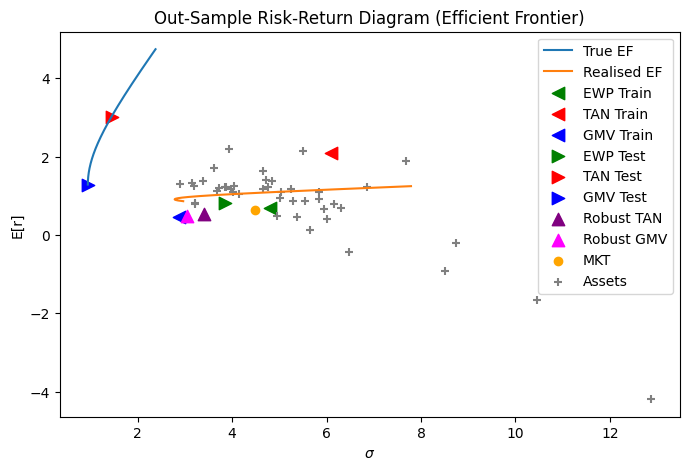

In [41]:
plot_ef2(mkt_train, excess_returns_train, excess_returns_test)

**2 Data Challenge**
-